In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class FederatedManager:

    def __init__(self, 
                 name,
                 dataloaders, 
                 test,
                 make_model,
                 loss_fn=nn.CrossEntropyLoss(), 
                 n_epochs=1, 
                 lr=1e-2, 
                 verbose=False, 
                 *args, **kwargs):
        
        self.dataloaders = dataloaders
        self.n_workers = len(dataloaders)
        self.n_epochs = n_epochs
        self.lr = lr
        self.verbose = verbose
        self.name = name
        self.history = {"test_loss": [], "test_acc": []}
        self.make_model = make_model
        self.model = self.make_model()
        self.model.train(False)
        self.loss_fn = loss_fn
        self.Xtest, self.ytest = consume_dataset(test)
        self.workers = []
        for i, dl in enumerate(dataloaders):
            self.workers.append(FederatedWorker(i, 
                                                self, 
                                                dl, 
                                                loss_fn,
                                                n_epochs=n_epochs, 
                                                lr=lr, 
                                                verbose=verbose,
                                                *args,
                                                **kwargs))
        self.worker_loss_histories = [[] for _ in self.workers]

    def round(self):
        """
        Do a round of federated learning:
         - instruct each worker to train and return its model
         - replace the server model the weighted average of the worker models
         - replace the worker models with the server model
        Workers with `participant=False` train but are not included in the
        weighted average and do not receive a copy of the server model.
        """
        updates = [w.train() for w in self.workers]
        self.fedavg(
            [u for u, w in zip(updates, self.workers) if w.participant]
        )
        self.push_model(w for w in self.workers if w.participant)
        self.record_loss()

    def fedavg(self, updates):
        """
        Replace the manager model with the weighted average of the node models.
        """
        N = sum(u["n_samples"] for u in updates)
        for key, value in self.model.state_dict().items():
            weight_sum = (
                u["state_dict"][key] * u["n_samples"] for u in updates
            )
            value[:] = sum(weight_sum) / N

    def push_model(self, workers):
        """
        Push manager model to a list of workers.
        """
        for worker in workers:
            worker.model = self.copy_model()

    def copy_model(self):
        """
        Return a copy of the current manager model.
        """
        model_copy = self.make_model()
        model_copy.load_state_dict(self.model.state_dict())
        return model_copy

    def evaluate_model(self, model=None):
        """
        Compute the loss and accuracy of model on test set.
        """
        model = model or self.model
        was_training = model.training
        model.train(False)
        with torch.no_grad():
            output = model(self.Xtest)
            loss = self.loss_fn(output, self.ytest).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(self.ytest.view_as(pred)).sum().item()
        model.train(was_training)
        return loss, 100. * correct / len(self.ytest)

    def record_loss(self):
        """
        Record loss of manager model and all worker models on test set.
        """
        loss_accuracy = self.evaluate_model()
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])

In [2]:
class FederatedWorker:

    def __init__(
        self, name, manager, dataloader, loss_fn, n_epochs=1, lr=1e-2,
        momentum=0.5, participant=True, verbose=False
    ):
        self.name = name
        self.manager = manager
        self.dataloader = dataloader
        self.n_epochs = n_epochs
        self.loss_fn = loss_fn
        self.participant = participant
        self.model = manager.copy_model()
        self.n_samples = len(self.dataloader.dataset)
        self.history = {"train_loss": [], "test_loss": [], "test_acc": []}
        self.lr = lr
        self.momentum = momentum
        self.verbose = verbose

    def train(self):
        """
        Train for n_epochs, then return the state dictionary of the model and
        the amount of training data used.
        """
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr,
                                    momentum=self.momentum)
        self.model.train(True)
        for epoch in range(self.n_epochs):
            for i, (x, y) in enumerate(self.dataloader):
                optimizer.zero_grad()
                ypred = self.model(x)
                train_loss = self.loss_fn(ypred, y)
                train_loss.backward()
                optimizer.step()
                self.history["train_loss"].append(train_loss.item())

        loss_accuracy = self.manager.evaluate_model(self.model)
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])
        
        if(self.verbose):
            print(
                '\twrkr {}\t\tloss: {:.4f}\tacc: {:.2%}'.format(
                    self.name,
                    self.history["test_loss"][-1],
                    self.history["test_acc"][-1] / 100,
                )
            )

        return {
            "state_dict": self.model.state_dict(),
            "n_samples": self.n_samples
        }

In [3]:
'''   

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#'''

In [4]:
from torch.utils.data import Subset

def make_fed_dloaders(dset, p=None, batch_size=64, shuffle=True):
    
    return [DataLoader(dset, batch_size, shuffle) for dset in make_fed_dsets(dset, p=p)]
    
def make_fed_dsets(dset, p=None):
    _, y = consume_dataset(dset)
    classes = set(y.numpy())
    n_classes = len(classes)
    idx_dset = index_to_dataset(y, p=p)
    dset_idx = [np.where(idx_dset == di)[0] for di in range(n_classes)]
    return [Subset(dset, di) for di in dset_idx]

def index_to_dataset(y, p=None):
    classes = set(y.numpy())
    n_classes = len(classes)
    p = p or 1/n_classes
    pnot = (1-p)/(n_classes-1)
    ps = np.full((n_classes, n_classes), pnot)
    np.fill_diagonal(ps, p)
    return np.array([np.random.choice(10, p=ps[yi]) for yi in y])

def check_dsets(dsets):
    for dset in dsets:
        _, y = consume_dataset(dset)
        print(Counter(y.numpy()))

def eval_new_mgr(name, train_dset, test_dset, p=0.0, n_rounds=50, target_acc=None, net=Net):
    dls = make_fed_dloaders(train_dset, p=p)
    mgr = FederatedManager(name, dls, test_dset, net)
    run_mgr(mgr, n_rounds, target_acc)
    plot_mgr(mgr)
    return mgr

In [5]:
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from collections import Counter
import numpy as np

def plot_digit_histogram(dls, title=''):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_ylabel('Digit Samples')
    ax.set_xlabel('Digit')
    
    ys = []
    for dset in tqdm([dl.dataset for dl in dls], desc='Tabulating datasets'):
        _, y = consume_dataset(dset)
        ys.append(sorted(Counter(y)))
        
    H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

def consume_dataset(dataset):
    data = list(zip(*dataset))
    X = torch.stack(data[0])
    y = torch.tensor(data[1])
    return X, y

In [6]:
def run_mgr(mgr, n_rounds=10, target_acc=None):
    
    target_met = False;
    
    if (target_acc):
        print('{} manager training with {} worker(s) for up to {} rounds or {:.2%} accuracy.'.format(
                mgr.name, mgr.n_workers, n_rounds, target_acc / 100,))
    else:
        print('{} manager training with {} worker(s) for {} rounds.'.format(
                mgr.name, mgr.n_workers, n_rounds,))

    for i in trange(n_rounds, desc='Rounds'):
        if(mgr.verbose):
            print('Round', i)
        mgr.round()
        if(mgr.verbose):
            print('\tcombined\tloss: {:.4f}\tacc: {:.2%}\n'.format(
                mgr.history['test_loss'][-1], mgr.history['test_acc'][-1] / 100,))
            
        if(target_acc and (mgr.history['test_acc'][-1] >= target_acc)):
            target_met = True
            break;

    if(target_met):
        print('{} manager stopped: met accuracy target of {:.2%} after {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, target_acc / 100, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))
    else:
        print('{} manager trained {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))

def plot_mgr(mgrs, plot_workers=False):
    
    if not isinstance(mgrs, list):
        mgrs = [mgrs]
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_loss'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_loss'], label=(m.name, 'Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend();
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_acc'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_acc'], label=(m.name, 'worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Accuracy")
    ax.legend();

    

In [195]:
def show_prediction(img, preds, correct_idx):
    
    preds = preds.data.numpy().squeeze()
    
    colors = ['blue'] * len(preds)
    colors[preds.argmax()] = 'red'
    colors[correct_idx] = 'green'

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())

    ax2.bar(range(10), preds, color=colors)
    ax2.set_aspect(0.25)
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(range(10))
    ax2.set_title('log(likelihood)')
    ax2.set_ylim(-20, 20)
    plt.tight_layout()

def get_eval_set(mgr):
    with torch.no_grad():
        output = mgr.model(mgr.Xtest)
    preds = output.argmax(dim=1, keepdim=True)
    return [{'x':mgr.Xtest[i],
             'probs':output[i],
             'pred':preds[i].item(),
             'y':mgr.ytest[i].item(),
             } for i in range(len(mgr.Xtest))]

def confusion_matrix(eval_set, norm=False, mirror=False):
    cm = np.zeros((10, 10))
    for ev in eval_set:
        cm[ev['y']][ev['pred']] += 1
        if mirror:
            cm[ev['pred']][ev['y']] += 1 # will amplify errors and remove directionality of error
    if norm:
        cm /=  cm.sum(axis=1)[:,np.newaxis]
    return cm

def show_model_confusion(mgr):
    eval_set = get_eval_set(mgr)
    misses = [ev for ev in eval_set if (ev['y'] != ev['pred'])]
    cm = confusion_matrix(misses, norm=False, mirror=True)
    #cm = np.log1p(cm)
    #print(np.array_str(cm, precision=4, suppress_small=True))
    plt.imshow(cm)
    plt.tight_layout()
    
def count_dsets(dsets, show_array=False, show_heatmap=False):
    cts = []
    for dset in tqdm(dsets, desc='Counting examples'):
        _, y = consume_dataset(dset)
        c = Counter(y.numpy())
        #print([c[i] for i in range(len(c))])
        cts.append([c[i] for i in range(len(c))])
    
    cts = np.array(cts)
    
    if show_array:
        print(cts)
        
    if show_heatmap:
        plt.imshow(np.log1p(cts), norm=plt.Normalize(vmin= 0.0, vmax=np.log1p(cts.sum())));
        plt.tight_layout();
        
    return np.array(cts)

# Common Data and Hyperparameters

In [8]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [128]:
from torch.utils.data import DataLoader

train_batch_size = 256
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dl = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

In [137]:
# default training targets
default_n_rounds = 10
default_target_acc = 95.0

# Non-Federated

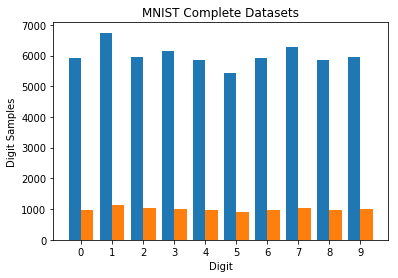

In [147]:
plot_digit_histogram([train_dl, test_dl], 'MNIST Complete Datasets')


[[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]]


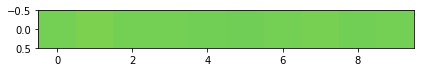

In [148]:
train_counts = count_dsets([train_dl.dataset], array=True, heatmap=True)

Non-Federated Full Dataset manager training with 1 worker(s) for up to 10 rounds or 95.00% accuracy.


Non-Federated Full Dataset manager stopped: met accuracy target of 95.00% after 9 rounds. (Test accuracy 95.10% and loss 0.1695.)


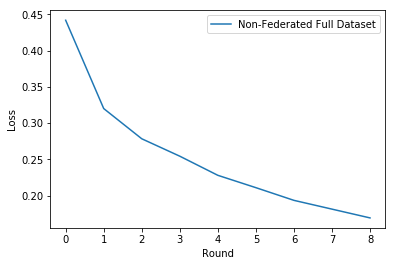

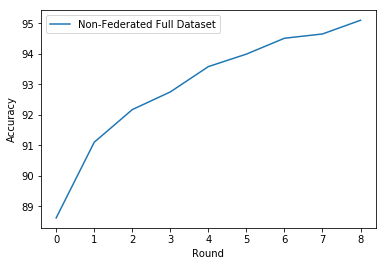

In [149]:
nonfed_alldata_mgr = FederatedManager('Non-Federated Full Dataset', [train_dl], test_dset, Net)

run_mgr(nonfed_alldata_mgr, default_n_rounds, target_acc=default_target_acc)

plot_mgr(nonfed_alldata_mgr)

# The Federated Approach

## Ten Equal Workers

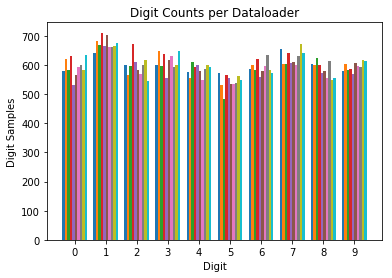

In [150]:
fed_equal_dls = make_fed_dloaders(train_dset)

plot_digit_histogram(fed_equal_dls, 'Digit Counts per Dataloader')

In [151]:
fed_equal_mgr = FederatedManager('Federated Unbiased', fed_equal_dls, test_dset, Net)

run_mgr(fed_equal_mgr, default_n_rounds, default_target_acc)

Federated Unbiased manager training with 10 worker(s) for up to 10 rounds or 95.00% accuracy.



Federated Unbiased manager trained 10 rounds. (Test accuracy 92.71% and loss 0.2481.)


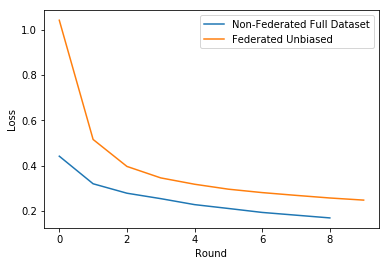

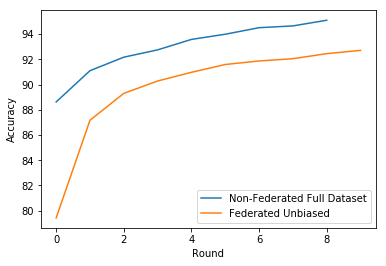

In [153]:
plot_mgr([nonfed_alldata_mgr, fed_equal_mgr])

# Federation with Varying Example Distributions Per Worker


## Spliting the Decks into Uneven Piles

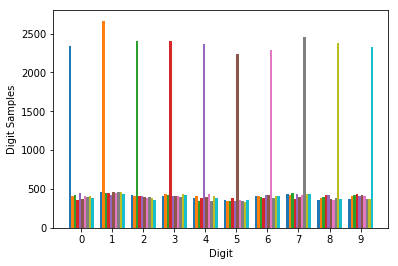

In [154]:
fed_weighted_dls = make_fed_dloaders(train_dset, p=0.4)
plot_digit_histogram(fed_weighted_dls)

In [155]:
check_dsets([dl.dataset for dl in fed_weighted_dls])

Counter({0: 2340, 1: 465, 7: 434, 2: 427, 3: 406, 6: 404, 4: 386, 9: 375, 5: 354, 8: 352})
Counter({1: 2665, 3: 431, 7: 426, 6: 409, 4: 405, 0: 404, 9: 403, 2: 403, 8: 386, 5: 351})
Counter({2: 2400, 1: 453, 7: 443, 3: 421, 9: 420, 0: 417, 6: 397, 8: 392, 5: 349, 4: 342})
Counter({3: 2400, 1: 453, 9: 434, 8: 422, 2: 405, 6: 388, 4: 384, 5: 384, 7: 376, 0: 359})
Counter({4: 2360, 0: 445, 7: 440, 1: 427, 8: 422, 6: 418, 2: 410, 9: 408, 3: 403, 5: 339})
Counter({5: 2242, 1: 467, 6: 418, 9: 417, 3: 408, 7: 402, 4: 394, 2: 390, 8: 377, 0: 369})
Counter({6: 2289, 1: 453, 4: 431, 7: 425, 9: 412, 0: 409, 3: 408, 2: 384, 8: 362, 5: 359})
Counter({7: 2455, 1: 458, 2: 396, 0: 391, 3: 391, 8: 383, 6: 382, 9: 375, 5: 350, 4: 345})
Counter({8: 2380, 1: 464, 3: 437, 7: 433, 4: 412, 0: 404, 6: 403, 2: 388, 9: 375, 5: 333})
Counter({9: 2330, 1: 437, 7: 431, 3: 426, 6: 410, 0: 385, 4: 383, 8: 375, 5: 360, 2: 355})


array([[581, 643, 600, 600, 576, 571, 587, 655, 605, 578],
       [620, 681, 565, 649, 554, 531, 601, 602, 600, 602],
       [583, 669, 597, 598, 610, 483, 582, 604, 623, 584],
       [632, 711, 671, 638, 593, 565, 621, 641, 599, 588],
       [531, 665, 611, 555, 600, 554, 558, 607, 571, 569],
       [565, 703, 583, 619, 581, 536, 581, 611, 580, 606],
       [593, 663, 568, 632, 548, 534, 598, 601, 554, 596],
       [601, 663, 600, 592, 587, 538, 634, 631, 614, 595],
       [584, 667, 619, 600, 599, 561, 582, 671, 549, 617],
       [633, 677, 544, 648, 594, 548, 574, 642, 556, 614]])

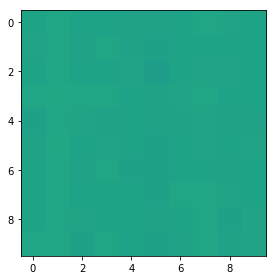

In [156]:
count_dsets([dl.dataset for dl in fed_equal_dls], show_array=False, show_heatmap=True)

array([[2340,  465,  427,  406,  386,  354,  404,  434,  352,  375],
       [ 404, 2665,  403,  431,  405,  351,  409,  426,  386,  403],
       [ 417,  453, 2400,  421,  342,  349,  397,  443,  392,  420],
       [ 359,  453,  405, 2400,  384,  384,  388,  376,  422,  434],
       [ 445,  427,  410,  403, 2360,  339,  418,  440,  422,  408],
       [ 369,  467,  390,  408,  394, 2242,  418,  402,  377,  417],
       [ 409,  453,  384,  408,  431,  359, 2289,  425,  362,  412],
       [ 391,  458,  396,  391,  345,  350,  382, 2455,  383,  375],
       [ 404,  464,  388,  437,  412,  333,  403,  433, 2380,  375],
       [ 385,  437,  355,  426,  383,  360,  410,  431,  375, 2330]])

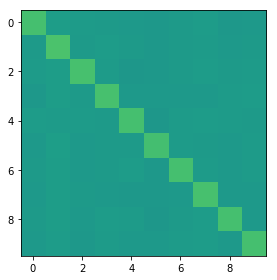

In [157]:
count_dsets([dl.dataset for dl in fed_weighted_dls], show_array=False, show_heatmap=True)

In [ ]:
fed_weighted_mgr = FederatedManager('Fed Bias', fed_weighted_dls, test_dset, Net)
run_mgr(fed_weighted_mgr, default_n_rounds, default_target_acc)
plot_mgr(fed_weighted_mgr)

# Difficult Decisions

These matrices should show us which number pairs our model has trouble discriminating. (Spoiler alert: its 4-9 and 3-5 pairs. The 5-8-9 triplet looks troublesome, too.)

In [ ]:
nonfed_alldata_mgr = FederatedManager('Non-Federated Full Dataset', [train_dl], test_dset, Net)

show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

In [ ]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

In [ ]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

In [ ]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

In [ ]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

In [ ]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

Let's see whether we can identify which digits give us the most trouble. Looks like 5, 8, and 9 are the most difficult.

In [ ]:
eval_set = get_eval_set(nonfed_alldata_mgr)
misses = [ev for ev in eval_set if (ev['y'] != ev['pred'])]
cm = confusion_matrix(misses, norm=False, mirror=True)

print(cm)
print(sorted([(cm[i].sum(), i, cm[i].argmax()) for i in range(len(cm))]))

In [ ]:
#TODO - Show the highest confidence picks

# Stacking the Deck Differently

In [ ]:
make_fed_dloaders()

In [ ]:
def make_custom_dsets(dset, n_workers=10, biases=[0.0]):
    
    dsets=[]
    
    
    
    return dls

In [224]:
n_workers = 5

#_, y = consume_dataset(train_dset)
classes = set(y.numpy())
n_classes = len(classes)

ps = np.array([[1] * n_workers] * n_classes)

# Incorporate bias parameters here
ps[9][0] = 1e9
ps[4][0] = 1e9
#ps[2][2] = 7
#ps[4][7] = 2

print('ps\n', np.array_str(ps, precision=3))

for x in range(10000):
    ps = np.transpose(ps)
    ps = np.array([ps[i]/ps[i].sum() for i in range(len(ps))])
    ps = np.transpose(ps)
    ps = np.array([ps[i]/ps[i].sum() for i in range(len(ps))])

print('ps\n', np.array_str(ps, precision=3))
print([sum(ps[i]) for i in range(len(ps))])
print([sum([ps[j][i]for j in range(len(ps))]) for i in range(len(ps[0]))])

'''
choices = []
for yi in y:
    #pyi = ps[yi]
    choice = np.random.choice(30, p=ps[0])
    #print('y', yi, 'ps[yi]', pyi, 'choice', choice, 'Counts', Counter(choices))
    choices.append(choice)

idx_dset = np.array(choices)


ps = [
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.4, 0.15, 0.15, 0.15, 0.15],
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.133, 0.2, 0.2, 0.2, 0.2],
    [0.4, 0.2, 0.2, 0.2, 0.2],
]
'''
idx_dset = np.array([np.random.choice(n_workers, p=ps[yi]) for yi in y])
print('idx_dset', type(idx_dset), len(idx_dset), idx_dset)

dset_idx = [np.where(idx_dset == di)[0] for di in range(n_workers)]
print('dset lengths', [len(dset_idx[i]) for i in range(len(dset_idx))], '=', sum([len(dset_idx[i]) for i in range(len(dset_idx))]))

custom_dsets = [Subset(train_dset, di) for di in dset_idx]

check_dsets(custom_dsets)

ps
 [[         1          1          1          1          1]
 [         1          1          1          1          1]
 [         1          1          1          1          1]
 [         1          1          1          1          1]
 [1000000000          1          1          1          1]
 [         1          1          1          1          1]
 [         1          1          1          1          1]
 [         1          1          1          1          1]
 [         1          1          1          1          1]
 [1000000000          1          1          1          1]]
ps
 [[1.042e-05 2.500e-01 2.500e-01 2.500e-01 2.500e-01]
 [1.042e-05 2.500e-01 2.500e-01 2.500e-01 2.500e-01]
 [1.042e-05 2.500e-01 2.500e-01 2.500e-01 2.500e-01]
 [1.042e-05 2.500e-01 2.500e-01 2.500e-01 2.500e-01]
 [9.999e-01 2.400e-05 2.400e-05 2.400e-05 2.400e-05]
 [1.042e-05 2.500e-01 2.500e-01 2.500e-01 2.500e-01]
 [1.042e-05 2.500e-01 2.500e-01 2.500e-01 2.500e-01]
 [1.042e-05 2.500e-01 2.500e-01 2.500e-0

In [225]:
custom_dls = [DataLoader(dset, batch_size=256, shuffle=True) for dset in custom_dsets]

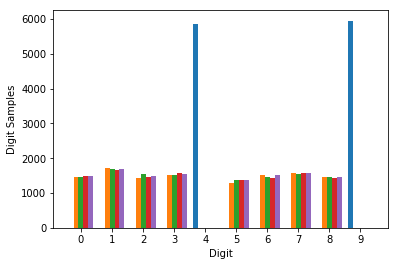

In [226]:
plot_digit_histogram(custom_dls)

In [227]:
count_dsets([dl.dataset for dl in custom_dls], show_array=True, show_heatmap=True)


[list([0, 0]) list([1460, 1704, 1443, 1510, 0, 1299, 1522, 1574])
 list([1466, 1692, 1558, 1508, 1, 1370, 1447, 1555, 1472])
 list([1496, 1663, 1457, 1569, 0, 1372, 1443, 1569])
 list([1501, 1683, 1500, 1544, 0, 1380, 1506, 1567])]


AttributeError: 'list' object has no attribute 'log1p'

Custom 4-9 manager training with 5 worker(s) for up to 10 rounds or 95.00% accuracy.


Round 0
	wrkr 0		loss: 4.8799	acc: 18.49%
	wrkr 1		loss: 1.9384	acc: 60.24%
	wrkr 2		loss: 1.9369	acc: 61.40%
	wrkr 3		loss: 1.9461	acc: 59.15%
	wrkr 4		loss: 1.9389	acc: 59.44%
	combined	loss: 1.8753	acc: 58.93%

Round 1
	wrkr 0		loss: 4.9649	acc: 18.51%
	wrkr 1		loss: 1.6858	acc: 67.34%
	wrkr 2		loss: 1.6856	acc: 68.29%
	wrkr 3		loss: 1.6839	acc: 67.53%
	wrkr 4		loss: 1.6894	acc: 67.74%
	combined	loss: 1.3906	acc: 67.02%

Round 2
	wrkr 0		loss: 4.6852	acc: 18.63%
	wrkr 1		loss: 1.5402	acc: 70.71%
	wrkr 2		loss: 1.5664	acc: 70.07%
	wrkr 3		loss: 1.5484	acc: 70.51%
	wrkr 4		loss: 1.5540	acc: 70.77%
	combined	loss: 1.1326	acc: 70.08%

Round 3
	wrkr 0		loss: 4.4425	acc: 18.83%
	wrkr 1		loss: 1.3992	acc: 71.46%
	wrkr 2		loss: 1.4038	acc: 71.56%
	wrkr 3		loss: 1.4276	acc: 71.62%
	wrkr 4		loss: 1.4042	acc: 71.78%
	combined	loss: 0.9646	acc: 71.23%

Round 4
	wrkr 0		loss: 4.2855	acc: 20.42%
	wrkr 1		loss: 1.2992	acc: 72.41%
	wrkr 2		loss: 1.2980	acc: 72.26%
	wrkr 3		loss: 1.3005	acc: 72.49%


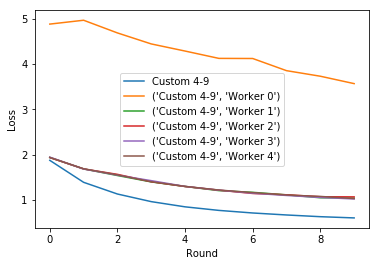

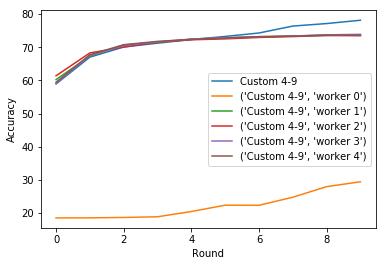

In [228]:
custom_mgr = FederatedManager('Custom 4-9', custom_dls, test_dset, Net, verbose = True)
run_mgr(custom_mgr, default_n_rounds, default_target_acc)
plot_mgr(custom_mgr, plot_workers=True)

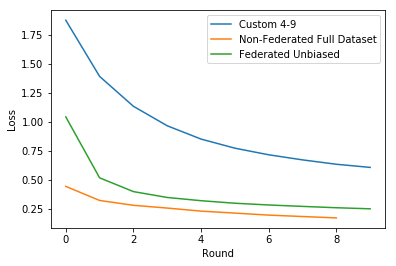

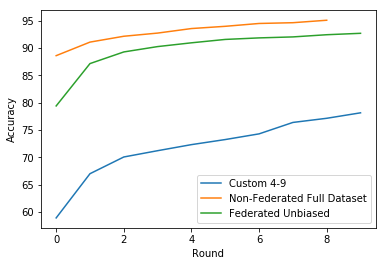

In [229]:
plot_mgr([custom_mgr, nonfed_alldata_mgr, fed_equal_mgr])

In [230]:
#count_dsets(subsets, heatmap=True)

In [ ]:
def make_fed_dloaders(dset, p=None, batch_size=64, shuffle=True):
    
    return [DataLoader(dset, batch_size, shuffle) for dset in make_fed_dsets(dset, p=p)]
    
def make_fed_dsets(dset, p=None):
    _, y = consume_dataset(dset)
    classes = set(y.numpy())
    n_classes = len(classes)
    idx_dset = index_to_dataset(y, p=p)
    dset_idx = [np.where(idx_dset == di)[0] for di in range(n_classes)]
    return [Subset(dset, di) for di in dset_idx]

def index_to_dataset(y, p=None):
    classes = set(y.numpy())
    n_classes = len(classes)
    p = p or 1/n_classes
    pnot = (1-p)/(n_classes-1)
    ps = np.full((n_classes, n_classes), pnot)
    np.fill_diagonal(ps, p)
    return np.array([np.random.choice(10, p=ps[yi]) for yi in y])

### Some tinkering to display the outputs of an evaluation

In [ ]:
import random

xs, ys = next(iter(test_dl))

idx = random.randint(0, len(xs))

x = xs[idx]
y = ys[idx]

model = nonfed_alldata_mgr.model
with torch.no_grad():
    log_pred = model(x)

show_prediction(x, log_pred, y)

pred_vals = sorted(zip(range(10), log_pred[0].tolist()), key=lambda item: item[1], reverse=True)

print('Actual Digit:   ', y.item())
print('Predicted Digit: {:d} ({:.2f})'.format(pred_vals[0][0], pred_vals[0][1]))
print('Nearest Digit  : {:d} ({:.2f})'.format(pred_vals[1][0], pred_vals[1][1]))
print('Farthest Digit : {:d} ({:.2f})'.format(pred_vals[9][0], pred_vals[9][1]))